In [1]:
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from joblib import load, dump
from ruamel.yaml import YAML
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import h5py
import periodictable as pt
from scipy.stats import loguniform
from palettable.cartocolors.sequential import SunsetDark_7

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV, ShuffleSplit, train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from umda import paths
from umda.data import load_data, load_pipeline
from umda import training

plt.style.use("publication.mpl")

In [2]:
seed = 1215677
normalize = True
mask = False

In [20]:
state = np.random.default_rng(seed)

full_X, full_cluster_ids, tmc1_df = load_data(exclude_hydrogen=True)
embedder = load_pipeline()

tmc1_X = np.vstack([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])
tmc1_y = np.log10(tmc1_df["Column density (cm^-2)"].to_numpy())

boot_X, boot_y = training.get_bootstrap_samples((tmc1_X, tmc1_y), seed, n_samples=400, replace=True, noise_scale=0.5)

(train_X, train_y), (test_X, test_y) = training.get_molecule_split_bootstrap(
    (tmc1_X, tmc1_y), seed=seed, n_samples=1000, replace=True,
    noise_scale=0.5, molecule_split=0.2, test_size=0.2
    )

In [5]:
with open("model_hparams.yml") as read_file:
    hparams = YAML().load(read_file)

## SVR tuning

In [60]:
# model = SVR("rbf", C=30., tol=1e-7, epsilon=1e-1)
model = SVR("rbf")

In [86]:
grid = RandomizedSearchCV(model, {"C": loguniform(1e-2, 1e3), "epsilon": loguniform(1e-1, 1e1)}, refit=False, n_iter=100, scoring="neg_mean_squared_error", random_state=seed)

In [87]:
result = grid.fit(train_X, train_y)

In [88]:
result.best_params_

{'C': 0.0991034751406821, 'epsilon': 1.9165510706536997}

In [91]:
result = SVR(**result.best_params_)

In [90]:
# train_X, test_X, train_y, test_y = train_test_split(boot_X, boot_y, test_size=0.2, random_state=seed, shuffle=True)

In [94]:
result = model.fit(train_X, train_y)

In [95]:
train_error = mean_squared_error(train_y, result.predict(train_X))
test_error = mean_squared_error(test_y, result.predict(test_X))

In [96]:
print(f"Train errror: {train_error:.2f}, test error: {test_error:.2f}")

Train errror: 0.89, test error: 1.41


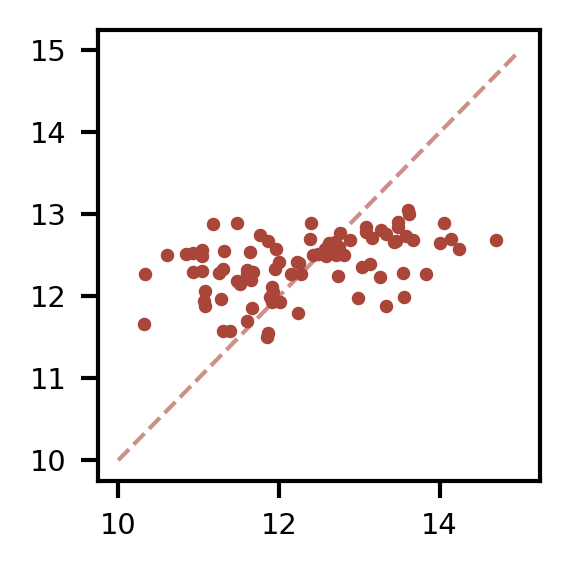

In [97]:
fig, ax = plt.subplots(figsize=(2,2))

ax.scatter(tmc1_y, result.predict(tmc1_X), s=5)
ax.plot(np.arange(10, 16), np.arange(10, 16), ls="--", alpha=0.6)
# ax.set(xlim=[10., 16.], ylim=[10., 16.])

## Bayesian ridge regression

In [292]:
grid = RandomizedSearchCV(BayesianRidge(normalize=False, lambda_1=1e4, lambda_2=1e4, tol=1e-6), 
    {
        # "lambda_1": loguniform(5e2, 5e3), "lambda_2": loguniform(5e2, 5e3),
        "alpha_1": loguniform(1e-8, 1e1), "alpha_2": loguniform(1e-8, 1e1),
        "alpha_init": loguniform(1e-8, 1e1), "lambda_init": loguniform(1e-2, 1e3)
     },
    cv=10, n_iter=300
    )

grid.fit(train_X, train_y)

RandomizedSearchCV(cv=10,
                   estimator=BayesianRidge(lambda_1=10000.0, lambda_2=10000.0,
                                           tol=1e-06),
                   n_iter=300,
                   param_distributions={'alpha_1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa71e739190>,
                                        'alpha_2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa71e6d61d0>,
                                        'alpha_init': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa71ea05d50>,
                                        'lambda_init': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa71ea81ed0>})

In [293]:
# model = BayesianRidge(normalize=False, lambda_1=1e3, lambda_2=1e3, tol=1e-5, compute_score=True, n_iter=1000)

In [294]:
print(grid.best_params_)
result = grid.best_estimator_
# result = model.fit(train_X, train_y)

{'alpha_1': 9.807732327984395, 'alpha_2': 0.024144291186711565, 'alpha_init': 2.0495896995309582e-05, 'lambda_init': 0.47450191389673974}


In [295]:
train_error = mean_squared_error(train_y, result.predict(train_X))
test_error = mean_squared_error(test_y, result.predict(test_X))

In [296]:
print(f"Train errror: {train_error:.2f}, test error: {test_error:.2f}")

Train errror: 0.34, test error: 4.91


In [297]:
r2_score(tmc1_y, result.predict(tmc1_X))

-0.183334283181523

In [298]:
print(result.lambda_, result.alpha_)

0.9949008138308706 2.815786864976616


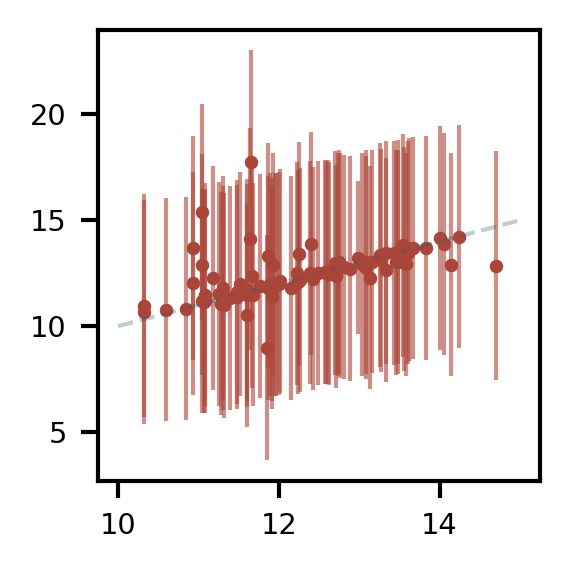

In [300]:
fig, ax = plt.subplots(figsize=(2,2))

ax.errorbar(tmc1_y, *result.predict(tmc1_X, return_std=True), fmt="o", markersize=1., alpha=0.6)
ax.scatter(tmc1_y, result.predict(tmc1_X), s=5.)
ax.plot(np.arange(10, 16), np.arange(10, 16), ls="--", alpha=0.3)
# ax.set(xlim=[10., 16.], ylim=[10., 16.])

## Regular ass ridge regression

In [21]:
grid = RandomizedSearchCV(Ridge(normalize=True), {"alpha": loguniform(1e-2, 1e2)}, refit=True, n_iter=200, scoring="neg_mean_squared_error")

In [22]:
grid.fit(train_X, train_y)

result = grid.best_estimator_

In [113]:
model = Ridge(alpha=2.)

In [14]:
result = model.fit(train_X, train_y)

NameError: name 'model' is not defined

In [23]:
train_error = mean_squared_error(train_y, result.predict(train_X))
test_error = mean_squared_error(test_y, result.predict(test_X))

In [28]:
print(f"Train errror: {train_error:.2f}, test error: {test_error:.2f}")
print(f"{r2_score(tmc1_y, result.predict(tmc1_X))}")

Train errror: 0.51, test error: 2.96
0.17740871954220772


In [25]:
result = grid.best_estimator_

In [29]:
grid.best_params_

{'alpha': 0.010085343366221931}

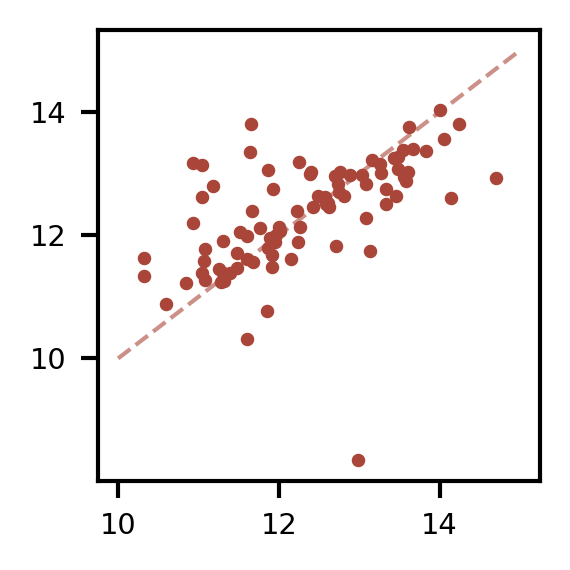

In [26]:
fig, ax = plt.subplots(figsize=(2,2))

ax.scatter(tmc1_y, result.predict(tmc1_X), s=5.)
ax.plot(np.arange(10, 16), np.arange(10, 16), ls="--", alpha=0.6)
# ax.set(xlim=[10., 16.], ylim=[10., 16.])